In [154]:
import h5py
import numpy as np
import operator
import visualisation
import pandas as pd
import matplotlib.pyplot as plt
from dtw import dtw


plt.rcParams["figure.figsize"] = (16,8)


In [151]:
PATH_TO_TRAINING_DATA = "additional_files_dreem/X_train_denoised_array.h5"
PATH_TO_TRAINING_TARGET = "data/y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))

/Users/Claudia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [152]:
X_train = np.array(h5_file.get('data'))

In [153]:
mask.shape

(4400, 91)

First we recover the segments corresponding to apnea and non apnea

In [83]:
L_individual_apnea = []
L_individual_normal = []

for idx_signal in range(4400):
    for t in range(90):
        if mask[idx_signal, t+1] == 0: #normal
            L_individual_normal += [X_train[:, idx_signal, t*100:(t+1)*100].T]
        else:
            L_individual_apnea += [X_train[:, idx_signal, t*100:(t+1)*100].T]
            
print(f"There are in total {len(L_individual_normal)} seconds correponding to normal sleep and {len(L_individual_apnea)} seconds of apnea.")

There are in total 368786 seconds correponding to normal sleep and 27214 seconds of apnea.


In [84]:
X_train_normal = np.asarray(L_individual_normal)
X_train_apnea = np.asarray(L_individual_apnea)


In [85]:
X_train_normal_ = X_train_normal.reshape((len(L_individual_normal)*100,8))
X_train_apnea_ = X_train_apnea.reshape((len(L_individual_apnea)*100,8))

In [87]:
signal_idx = 0
window_length = 100
mean_filter = np.ones(window_length)/window_length

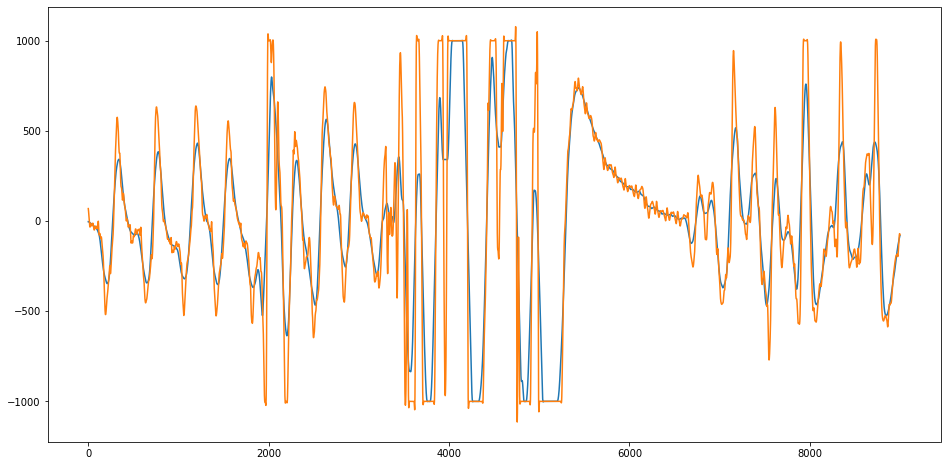

In [89]:
plt.plot(np.convolve(X_train[signal_idx, 0], mean_filter, mode='same'))
plt.plot(X_train[signal_idx, 0])


In [71]:
def vectorization_matrices(n):
    """
    Returns the matrices used in the vectorized problem
    Mdup [n**2, (n*(n+1))//2] is the duplication matrix 
    A [n+1, (n*(n+1))//2 ] is the equality constraints matrix
    B [(n*(n-1))//2, (n*(n+1))//2] is the inequality constraints matrix
    """
    # Construction of Mdup
    
    Mdup = np.zeros((n**2, (n*(n+1))//2))


    l = [0]
    for i in range(n-1):
        l += [l[-1] + n-i]

    idx = 0
    extra = 0

    for i in range(len(l)):
        Mdup[l[i] + extra : l[i] + extra  + n-i, l[i]: l[i] + n-i] = np.eye(n-i) #identity matrix
        cnt = 1
        while l[i] + extra + n*cnt < n**2:
            Mdup[l[i] + extra + n*cnt, l[i]+cnt] = 1
            cnt +=1
        extra += 1 + i 
        
    # Construction of A
    
    A = np.zeros((n+1, (n*(n+1))//2))

    idx = 0
    for i in range(n):
        M = np.eye(n-i)
        M[0,:] = np.ones(n-i)
        A[1+i:, idx:idx+n-i] = M
        A[0,idx] =1
        idx += n-i
        
    # Construction of B
    B = np.zeros(((n*(n-1))//2, (n*(n+1))//2))
    I = np.eye((n*(n-1))//2)

    idx_b = 1
    idx_i = 0

    for i in range(n-1,0,-1):
        B[:, idx_b:idx_b+i] = I[:, idx_i:idx_i+i]
        idx_b += i + 1
        idx_i += i
        
    return(Mdup, A, B)

In [73]:
def de_vectorize(vech, Mdup):
    vec = Mdup @ vech
    n = int(np.sqrt(vec.shape[0]))
    L = np.reshape(vec, (n,n))
    return(L)

In [77]:
np.linalg.inv(Mdup.T @ Mdup)

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ]])

In [78]:
Mdup @ np.linalg.inv(Mdup.T @ Mdup) @ (Mdup.T)

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ]])

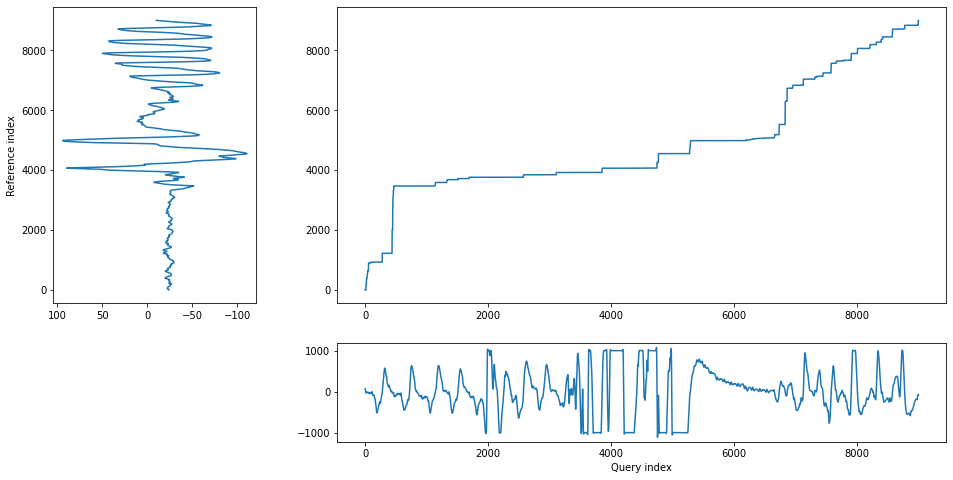

<AxesSubplot:>

In [220]:
from dtw import dtw

d1 = X_train[0,0]
d2 = X_train[1,0]
dist_matrix = dtw(d1,d2, keep_internals=True)

dist_matrix.plot(type="threeway", figsize=(10,10))

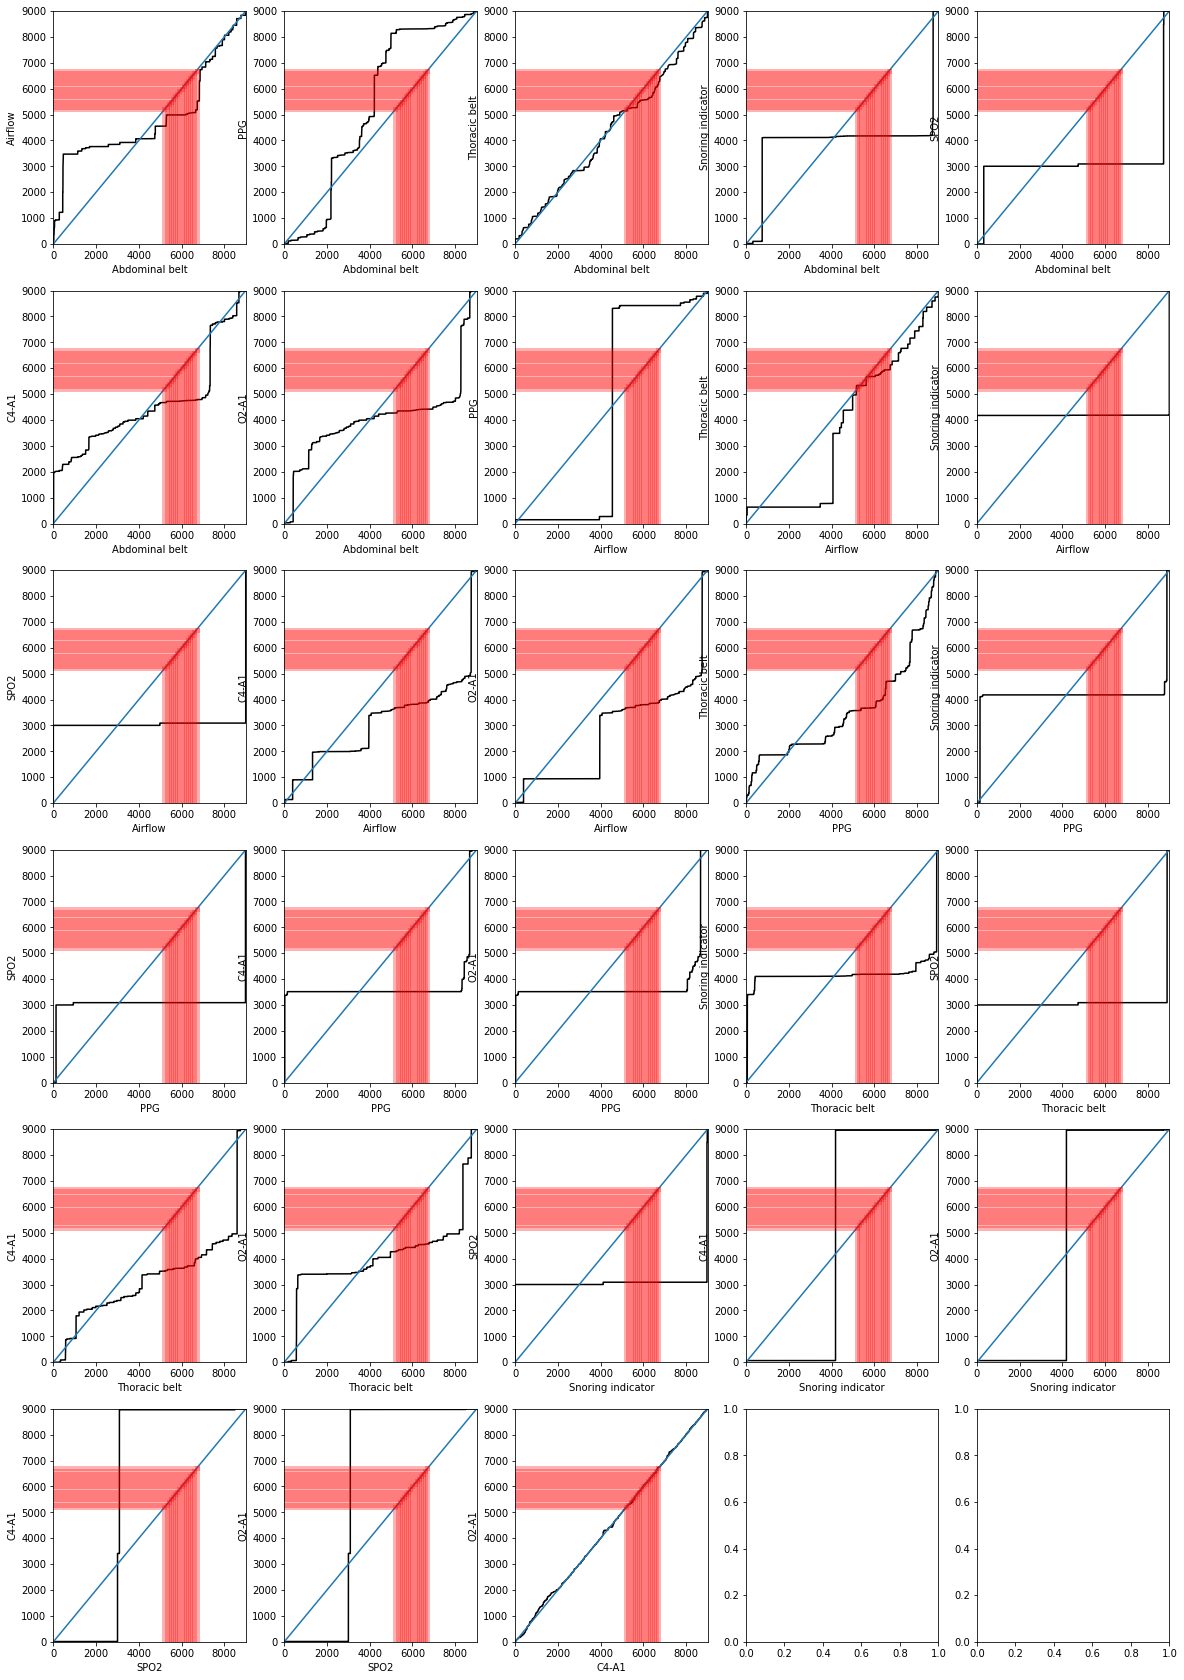

In [268]:
mask0 = mask[0,1:]
apneas_0 = np.where(mask0 == 1)[0]

labels = ["Abdominal belt", "Airflow", "PPG", "Thoracic belt", "Snoring indicator", "SPO2", "C4-A1", "O2-A1"]
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(20,30))

cnt=0
for k in range(7):
    d1 = X_train[k,0]
    for i in range(k+1,8):
        d2 = X_train[i,0]
        dist_matrix = dtw(d1,d2, keep_internals=True)
        ax[cnt//5,cnt%5].plot(dist_matrix.index1, dist_matrix.index2, c='k')
        ax[cnt//5,cnt%5].plot([j for j in range(9000)], [j for j in range(9000)])
        ax[cnt//5,cnt%5].set_xlim(0, 9000)
        ax[cnt//5,cnt%5].set_ylim(0, 9000)

        for idx in range(apneas_0.size):
            ax[cnt//5,cnt%5].axvline(apneas_0[idx]*100, ymin=0, ymax = (apneas_0[idx]*100)/9000, color='r', linewidth=5, alpha=0.3)
            ax[cnt//5,cnt%5].axhline(apneas_0[idx]*100, xmin=0, xmax = (apneas_0[idx]*100)/9000, color='r', linewidth=5, alpha=0.3)

        ax[cnt//5,cnt%5].set_xlabel(labels[k])
        ax[cnt//5,cnt%5].set_ylabel(labels[i])
        cnt+=1
    

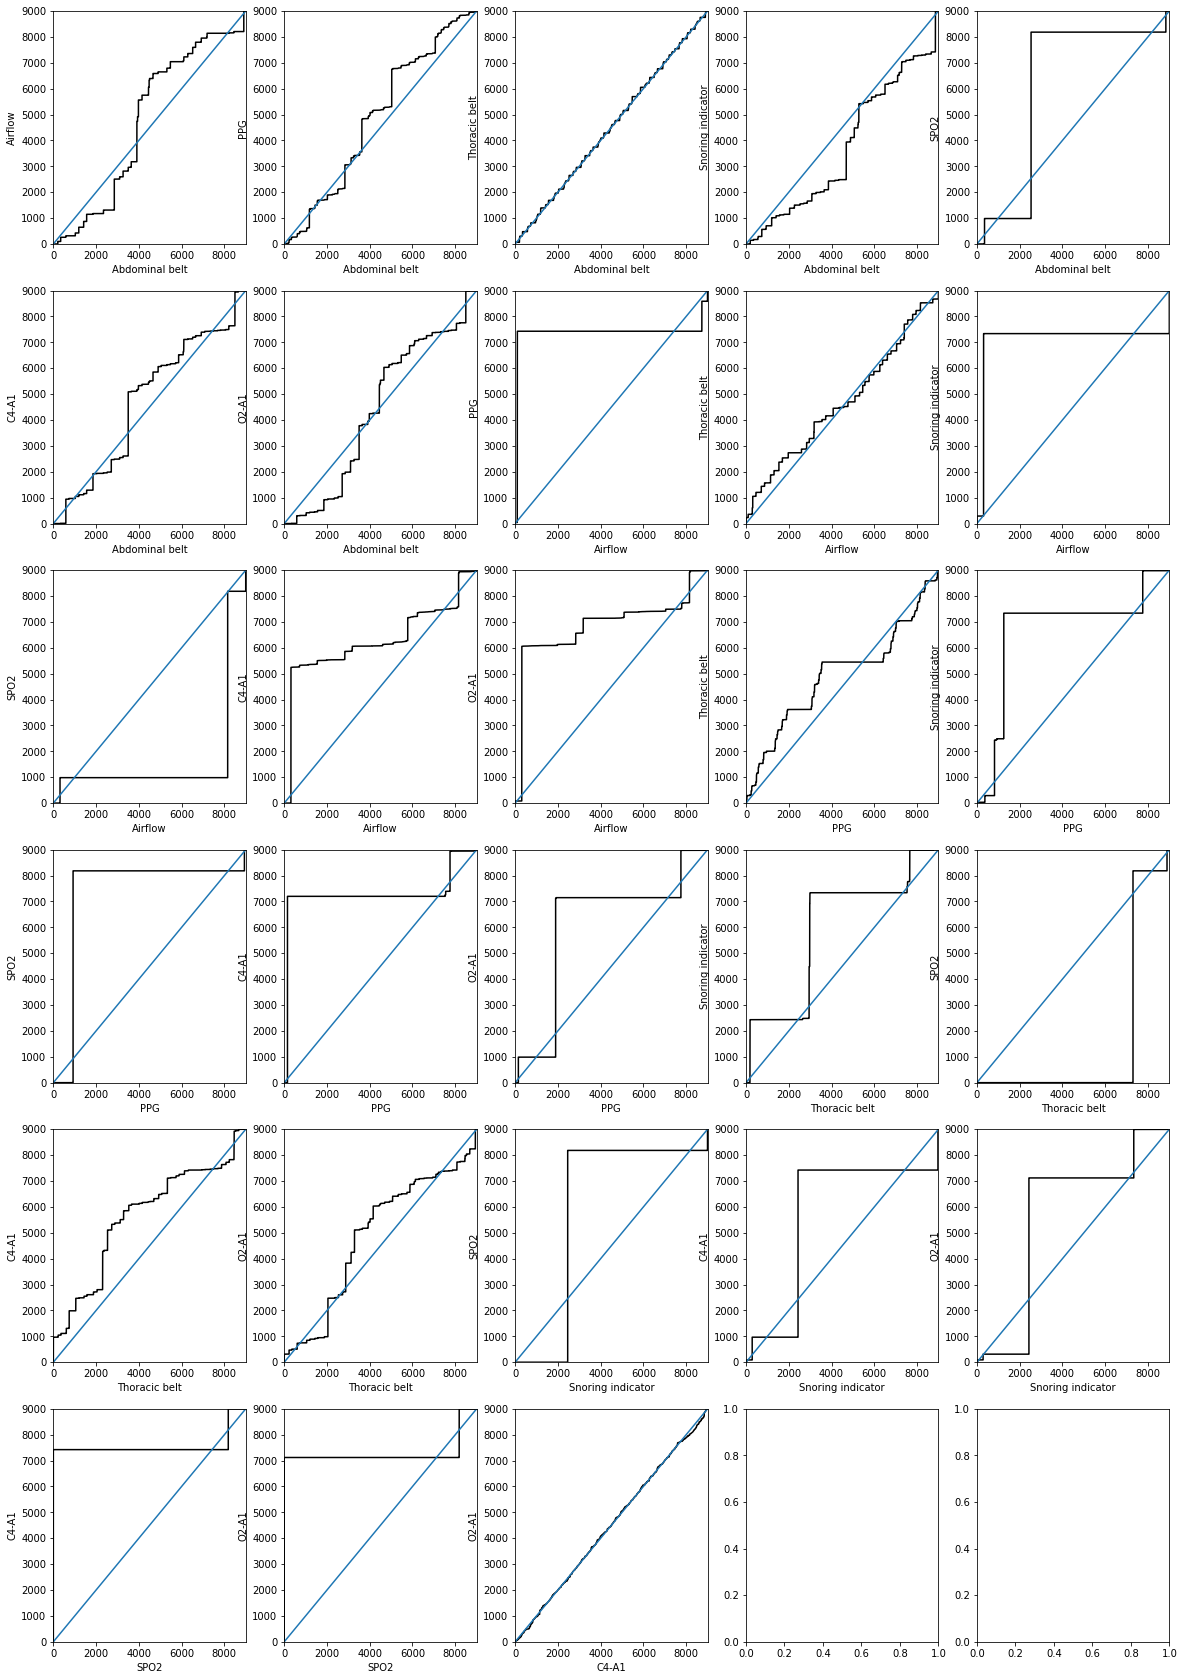

In [269]:
mask0 = mask[1,1:]
apneas_0 = np.where(mask0 == 1)[0]

labels = ["Abdominal belt", "Airflow", "PPG", "Thoracic belt", "Snoring indicator", "SPO2", "C4-A1", "O2-A1"]
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(20,30))

cnt=0
for k in range(7):
    d1 = X_train[k,1]
    for i in range(k+1,8):
        d2 = X_train[i,1]
        dist_matrix = dtw(d1,d2, keep_internals=True)
        ax[cnt//5,cnt%5].plot(dist_matrix.index1, dist_matrix.index2, c='k')
        ax[cnt//5,cnt%5].plot([j for j in range(9000)], [j for j in range(9000)])
        ax[cnt//5,cnt%5].set_xlim(0, 9000)
        ax[cnt//5,cnt%5].set_ylim(0, 9000)

        for idx in range(apneas_0.size):
            ax[cnt//5,cnt%5].axvline(apneas_0[idx]*100, ymin=0, ymax = (apneas_0[idx]*100)/9000, color='r', linewidth=5, alpha=0.3)
            ax[cnt//5,cnt%5].axhline(apneas_0[idx]*100, xmin=0, xmax = (apneas_0[idx]*100)/9000, color='r', linewidth=5, alpha=0.3)

        ax[cnt//5,cnt%5].set_xlabel(labels[k])
        ax[cnt//5,cnt%5].set_ylabel(labels[i])
        cnt+=1
    

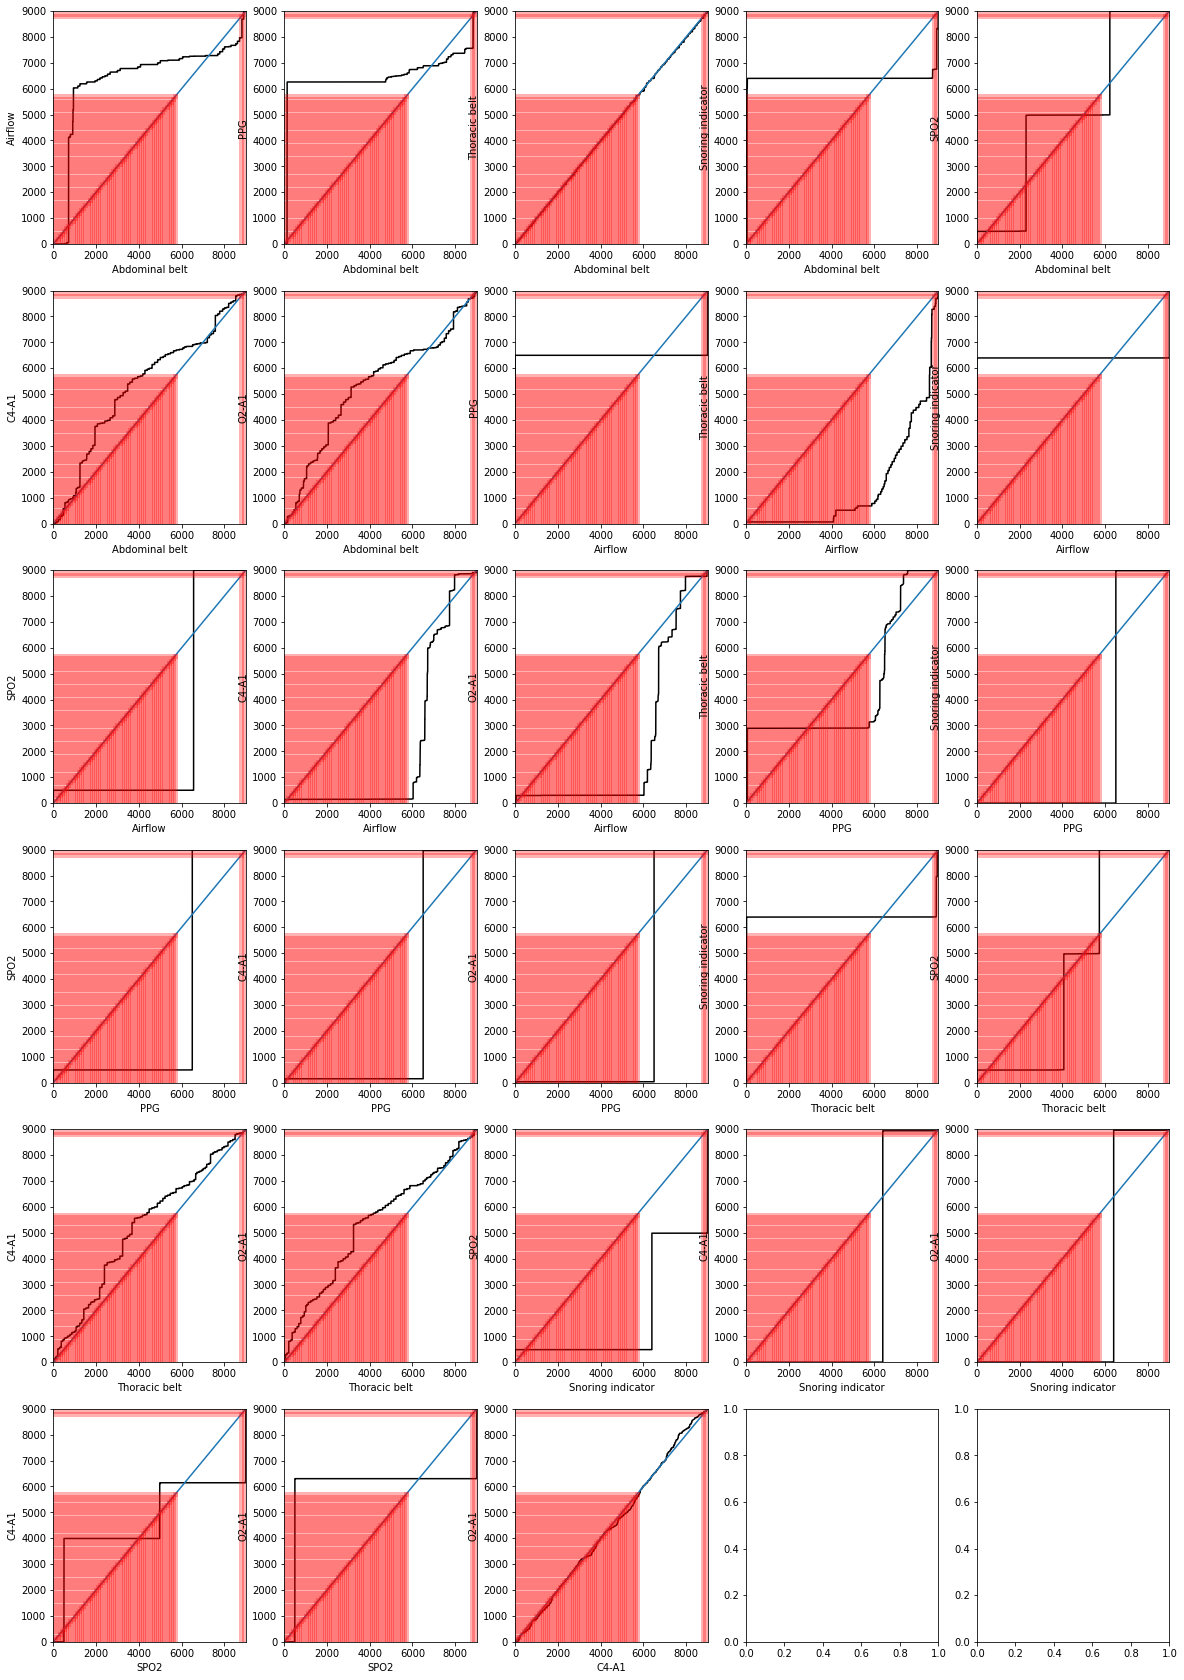

In [270]:
mask0 = mask[890,1:]
apneas_0 = np.where(mask0 == 1)[0]

labels = ["Abdominal belt", "Airflow", "PPG", "Thoracic belt", "Snoring indicator", "SPO2", "C4-A1", "O2-A1"]
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(20,30))

cnt=0
for k in range(7):
    d1 = X_train[k,890]
    for i in range(k+1,8):
        d2 = X_train[i,890]
        dist_matrix = dtw(d1,d2, keep_internals=True)
        ax[cnt//5,cnt%5].plot(dist_matrix.index1, dist_matrix.index2, c='k')
        ax[cnt//5,cnt%5].plot([j for j in range(9000)], [j for j in range(9000)])
        ax[cnt//5,cnt%5].set_xlim(0, 9000)
        ax[cnt//5,cnt%5].set_ylim(0, 9000)

        for idx in range(apneas_0.size):
            ax[cnt//5,cnt%5].axvline(apneas_0[idx]*100, ymin=0, ymax = (apneas_0[idx]*100)/9000, color='r', linewidth=5, alpha=0.3)
            ax[cnt//5,cnt%5].axhline(apneas_0[idx]*100, xmin=0, xmax = (apneas_0[idx]*100)/9000, color='r', linewidth=5, alpha=0.3)

        ax[cnt//5,cnt%5].set_xlabel(labels[k])
        ax[cnt//5,cnt%5].set_ylabel(labels[i])
        cnt+=1
    

In [264]:
idx_apnee_signals = []
for i in range(4400):
    if 1 in mask[i,1:]:
        idx_apnee_signals += [i]

In [265]:
idx_apnee_signals

[0,
 18,
 36,
 52,
 64,
 108,
 110,
 124,
 140,
 168,
 216,
 217,
 226,
 227,
 236,
 253,
 280,
 297,
 304,
 348,
 350,
 353,
 361,
 379,
 397,
 404,
 406,
 407,
 408,
 415,
 416,
 421,
 424,
 426,
 435,
 436,
 437,
 438,
 443,
 446,
 449,
 450,
 461,
 462,
 472,
 473,
 479,
 482,
 483,
 487,
 488,
 489,
 495,
 498,
 499,
 504,
 505,
 506,
 511,
 516,
 518,
 520,
 523,
 525,
 527,
 528,
 541,
 542,
 544,
 550,
 551,
 556,
 557,
 561,
 563,
 566,
 567,
 569,
 575,
 577,
 579,
 587,
 588,
 590,
 592,
 593,
 596,
 598,
 599,
 604,
 609,
 613,
 616,
 618,
 621,
 623,
 627,
 644,
 647,
 649,
 652,
 654,
 655,
 661,
 664,
 666,
 668,
 671,
 674,
 678,
 684,
 685,
 686,
 692,
 696,
 698,
 706,
 714,
 719,
 724,
 726,
 732,
 735,
 739,
 748,
 752,
 754,
 756,
 757,
 758,
 760,
 761,
 762,
 765,
 772,
 773,
 774,
 781,
 782,
 787,
 793,
 794,
 796,
 799,
 802,
 805,
 806,
 807,
 808,
 809,
 813,
 815,
 816,
 817,
 818,
 819,
 823,
 824,
 825,
 827,
 828,
 829,
 831,
 832,
 833,
 834,
 840,
 845